# Flower classifier

_Author: Baccega Sandro_

In this notebook we will classify Oxford's `102 Category Flower Dataset` that can be found [here](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html).

Another required asset to run this code is `Oxford-102_Flower_dataset_labels.txt` from JosephKJ that can be found [here](https://gist.github.com/JosephKJ/94c7728ed1a8e0cd87fe6a029769cde1), this external file contains the flowers names.

---


## Imports and constants


In [209]:
from scipy.io import loadmat
import pandas as pd
import numpy as np
import torch
import shutil
import time
import json
import os
import copy
import matplotlib.pyplot as plt
import skimage.io as skio 

# import seaborn as sns
import numpy as np
from PIL import Image
from collections import OrderedDict
from torch import nn, optim
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import Dataset
from torch.autograd import Variable
from torchvision import datasets, transforms

# --- CONSTANTS AND HYPERPARAMETERS ---

SEED = 151836
DATASET_SPLIT = 0.8  # Get 80% of dataset for training, the rest for validating

BATCH_SIZE = 64
N_EPOCHS = 4
HIDDEN_LAYERS_OUTPUT_CHANNELS = [8, 16]
CROPPED_IMAGES_SIZE = 200
LEARNING_RATE = 0.001

# Assets location

RAW_IMAGE_LABELS_MAT_FILE = "assets/imagelabels.mat"
RAW_DATASET_LABELS_FILE = "assets/Oxford-102_Flower_dataset_labels.txt"
RAW_DATASET_IMAGES_FOLDER = "assets/jpg"
RAW_SEGMENTED_IMAGES_FOLDER = "assets/segmim"

# Data folder location

DATASET_IMAGES_FOLDER = "data/images"

# Setting seed
torch.manual_seed(SEED)

# Set device to use for computations
device = (
    "cuda"
    if torch.cuda.is_available()
    else ("mps" if torch.backends.mps.is_available() else "cpu")
)

print(f"-----\nPyTorch version: {torch.__version__}\nDevice: {device}\n-----")


-----
PyTorch version: 1.13.0.dev20220608
Device: mps
-----


## Creating the sorted data folder


In [210]:
# images_list = sorted(os.listdir(RAW_DATASET_IMAGES_FOLDER))
# labels_arr = loadmat(RAW_IMAGE_LABELS_MAT_FILE)["labels"]
# labels_arr -= 1
# labels_list = list(labels_arr[0,:])
# metadata = pd.DataFrame({'images': images_list,'labels': labels_list})

metadata = pd.DataFrame()
metadata['images'] = sorted(os.listdir(RAW_DATASET_IMAGES_FOLDER))
metadata["labels"] = loadmat(RAW_IMAGE_LABELS_MAT_FILE)["labels"][0] - 1 
metadata['labels'] = metadata['labels'].astype(str)

# print(metadata)

groups = metadata.groupby("labels")["images"].apply(list)

# If data folder exists, do not create images folder
# if not os.path.isdir(DATASET_IMAGES_FOLDER):
#     print("Creating data folder")
#     os.mkdir(DATASET_IMAGES_FOLDER)

#     for category, images in groups.items():
#         os.mkdir("{}/{}".format(DATASET_IMAGES_FOLDER, category))
#         for image in images:
#             shutil.copyfile(
#                 "{}/{}".format(RAW_DATASET_IMAGES_FOLDER, image),
#                 "{}/{}/{}".format(DATASET_IMAGES_FOLDER, category, image),
#             )

#     print("Done - data folder creation")
# else:
#     print("Skipping - data folder creation")


# Creating category to label reference
rawLabelReferenceData = np.loadtxt(RAW_DATASET_LABELS_FILE, dtype="str", delimiter="\n")
labelReferenceData = list(map(lambda str: str[2:-1], rawLabelReferenceData))

i = 0
labelReference = {}

for category, images in groups.items():
    labelReference[category] = labelReferenceData[i]
    i += 1

print("Done - label reference creation")
# print(labelReference)


Done - label reference creation


## Creating the datasets


Train dataset size: 6551
Validation dataset size: 1638


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


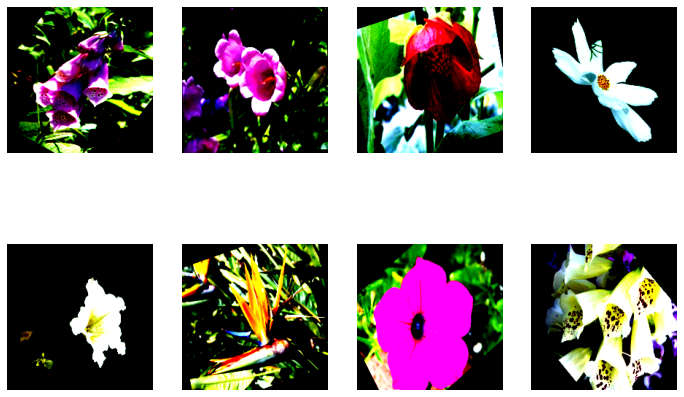

In [214]:
class FlowerDateset(Dataset):
    def __init__(self, metadata, transform=None):
        self.metadata = metadata
        self.transform = transform

    def __getitem__(self, index):
        image_path = self.metadata.iloc[index, 0]
        image = skio.imread("{}/{}".format(RAW_DATASET_IMAGES_FOLDER, image_path))
        label = torch.tensor(int(self.metadata.iloc[index, 1]))
        label = F.one_hot(label, num_classes=102)
        label = label.float()
        if self.transform:
            image = self.transform(image)

        return (image, label)

    def __len__(self):
        return len(self.metadata)


transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.RandomRotation(45),
        transforms.RandomHorizontalFlip(),
        transforms.Resize((CROPPED_IMAGES_SIZE, CROPPED_IMAGES_SIZE)),
        # transforms.CenterCrop(CROPPED_IMAGES_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)


dataset = FlowerDateset(metadata, transform=transform)

train_set_size = int(len(dataset) * DATASET_SPLIT)
valid_set_size = len(dataset) - train_set_size

train_dataset, validation_dataset = data.random_split(
    dataset, [train_set_size, valid_set_size]
)

train_dataloader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = data.DataLoader(
    validation_dataset, batch_size=BATCH_SIZE, shuffle=True
)

print("Train dataset size: {}".format(len(train_dataset)))
print("Validation dataset size: {}".format(len(validation_dataset)))

n_rows = 2
n_cols = 4

for x, y in train_dataloader:
    x = x.to(device)
    fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 8))
    for i in range(n_rows):
        for j in range(n_cols):
            ax[i, j].imshow(x[(i * n_cols) + j].cpu().permute(1,2,0))
            ax[i, j].axis("off")
            #ax[i, j].set_title(labelReference[label])
    break


## Creating the model

Here we create our CNN model with 2 simple layers.

We use a kernel_size=(3,3), stride=(1,1) and padding=(1,1) in order to have a same convolution.

We use a MaxPool2d to reduce the size of the network by half efficiently.

We use the Adam optimizer and the CrossEntropyLoss as our loss function.


In [212]:
class MyCNNModel(nn.Module):
    def __init__(
        self,
        num_in_channels=3,
        num_out_channels=HIDDEN_LAYERS_OUTPUT_CHANNELS,
        img_width=CROPPED_IMAGES_SIZE,
        img_height=CROPPED_IMAGES_SIZE,
        num_classes=102,
    ):
        super(MyCNNModel, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=num_in_channels,
            out_channels=num_out_channels[0],
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.conv2 = nn.Conv2d(
            in_channels=num_out_channels[0],
            out_channels=num_out_channels[1],
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.fc = nn.Linear(
            in_features=int(img_width / 4) * int(img_height / 4) * num_out_channels[1],
            out_features=num_classes,
        )

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.fc(x.reshape(x.shape[0], -1))
        return x


model = MyCNNModel()

# Testing the model
x = torch.randn(32, 3, CROPPED_IMAGES_SIZE, CROPPED_IMAGES_SIZE)
y = model(x)
print(y.shape)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Loss function
criterion = nn.CrossEntropyLoss()


torch.Size([32, 102])


## Train model


## Testing
